# Tree Growth Analysis

### 1. Methodology

The aim of the assignment is to examine the relationships between the outcome (Y) and predictor variables (X). The list of variables and corresponding descriptions provided below:

##### Outcome variables (Y):

1. Tree Survival Rate - % of trees survived/became mature.
2. Diameter -  average DBH (cm)
3. Height - average height (meters)
4. Stand Volume - volume column refers to standing tree volume by cubic meters of all trees
at the farm at that given age

##### Performance drivers (X):

1. FA Zone - facilitator zone indicates field staff management variability and agro-ecological
growing conditions.
2. Field Manager - a proxy for management talent.
3. Management Quality - farmer classification designated by our operations team of how
effectively a farmer delivered key actions (weeding, etc.) that are known to impact tree survival and growth.
4. Suitability - a high-level classification defined by an external consultant, primarily based on
digitized versions of 1930’s maps on soil type, combined with his knowledge of silviculture.
5. Planting Year - we can expect significant year-to-year variability, mostly driven by fluctuation in
rainfall timing/volume, plus other longtail factors (e.g. seedling quality or management quality
within a given year).
6. Location - area name. 
7. SiteIndexClass - growth rate of the farm.
8. Area - total farm land area.
9. Age - age of the farm in years. 
10. Stems per hectare - number of stems/trees per hectare.

Since all the outcomes variables are continuous, I will be using regression analysis to estimate the importance of predictors on the outcomes variables. I will create 4 model version using different outcomes variable (Y) and the same list of performance drivers including the control variables listed in the dataset, which were not highlighted for review. In case those variables are significant, it will allow me to reduce the errors and improve precision of insights when it comes to the variables of interest.

In addition, I will be using different regression algorithms such as Linear, Lasso, Ridge and Random Forest to evaluate the best model fit. 

### 2. Challenges and Limitations

The list of provided variables consists of a number of categorical variables with high cardinality, which makes it’s challenging to use it in the regression analysis (each category is a separate dummy variable and it’s not advisable to have a large number of columns). 

When it comes to outliers, using a z-score method, I have found that my sample size dropped to N=3327 after removing suspected data points. This means that there’s relatively many data points that need to be further investigated. The process of data collection in the field might, in particular, suggest data quality issues. However, removing outliers did not significantly affect my model results and, taken the fact that I am not able to investigate this further to confirm whether these are natural outliers or data quality issues, I have decided to keep it in the analysis. 

### 3. Results

When it comes to the tree size indicators: volume, diameter and height - all the predictors of interest (FA Zone, field manager, management quality, suitability, planting year) are significant drivers of the performance. Random Forest Regression showed to be the best model fit with the Adj R - Squared for the volume outcome - 0.61, diameter - 0.72 and  height - 0.92. In addition, p-values for all the variables in the list were less than 0.05, showing that all indicators have significant relationships with the outcomes variables. When it comes to SiteIndexClass, it has a positive association with all the tree size indicators, meaning higher index results in larger volume, diameter and height. Similarly, tree age (or year of planting) has a positive association with all the tree size outcomes. On the other hand, area has a negative relationship with volume and diameter, but positive association with height. This is a surprising finding since I would expect all the tree size metrics would be affected similarly by the size of the area planted. When it comes to the interpretation of the categorical variables, it’s less straightforward and would require additional analysis output. 

In addition, the model for the tree survival rate returned very weak results - Adj R-Squared is at 0.11 (only 11% of variation in the tree survival rate is explained by the X variables), indicating that the model is missing crucial drivers of tree survival rate. This could be factors such as weather conditions (rainfall, hours of sunlight), land fertility indicators etc. Due to such low model predictive power, it's not advisable to comment on the impact of each variable on the outcome variable, however I would notice that land suitability and FA zone seem particularly unrelated to tree survival rate. 


### 4. Recommendations

- Further research is required to better understand the drivers behind the tree survival rate. This is important since the tree survival rate is an important factor influencing business performance. 
- Further invest in the field manager recruitment and training processes, as they prove to be playing an important role in the productivity of farm. 
- Similarly, since farmer management quality has benefited the farm performance, additional farmer extension services could help further improve business performance and drive towards profitability.  


### The workbook contains of two notebooks: Exploratory Data Analysis (EDA) is presented in a separate file - 3.1. EDA Data Science Irma Sirutyte.html (pandas profile report can only be exported separately). 

### Importing libraries

In [1]:
### Importing the libraries needed for the the analysis
import pandas as pd
from pandas_profiling import ProfileReport

import numpy as np
import seaborn as sb

from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from functools import reduce

from sklearn.model_selection import train_test_split, cross_val_score, KFold
import statsmodels.api as sm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

/Users/irmasirutyte/anaconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data Import

In [2]:
### import the dataset and look at a preview
df_komaza = pd.read_csv('enumeration_data_komaza.csv')
df_komaza.head()

,stand id,county,location,FA_zone,Field Manager,mgmtQuality,species,siteIndexClass,suitability,area,planting year,age,volume,stems per hectare,tree survival rate,diameter,height
0,klf-2008-0001,klf,Ngerenya,zone-01-088,Alfred,mid,Eucalyptus GC,SI12,Very suitable,0.22,2008,11.17,97.51,691.0,62.2,18.56,14.26
1,klf-2008-0002,klf,Ngerenya,zone-01-088,Alfred,good,Eucalyptus GC,SI16,Very suitable,0.15,2008,11.17,182.70,965.0,86.9,19.48,18.10
2,klf-2008-0004,klf,Palakumi,208,Tyson,mid,Eucalyptus GC,SI12,Not suitable,0.12,2008,10.67,77.65,1308.0,117.7,13.10,14.15
3,klf-2008-0005,klf,Ngerenya,zone-01-128,Mathias,inaccessible,Eucalyptus GC,SI12,Very suitable,0.17,2008,11.17,25.11,238.0,21.4,16.45,12.95
4,klf-2008-0006,klf,Palakumi,zone-01-088,Alfred,good,Eucalyptus GC,SI14,Not suitable,0.03,2008,10.75,129.20,1329.0,119.6,15.32,15.68


## 1. Exploratory Data Analysis (EDA)
First step in the analysis is to better understand your data. I will be using the profile pandas library to generate a comprehensive report. The full report is also attached to the main file for you to review. 

In [3]:
profile = ProfileReport(df_komaza)
#profile.to_widgets()
profile.to_file(output_file='EDA_output.html')

In [4]:
df_komaza.describe(include='all')

,stand id,county,location,FA_zone,Field Manager,mgmtQuality,species,siteIndexClass,suitability,area,planting year,age,volume,stems per hectare,tree survival rate,diameter,height
count,3738,3738,3738,3738,3738,3738,3738,3738,3738,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000
unique,3738,1,27,137,9,4,1,6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,klf-2011-0636,klf,Mtsara wa tsatsu,zone-01-000,No FM,good,Eucalyptus GC,SI12,Not suitable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,3738,679,448,1411,1937,3738,1182,1773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.113344,2011.834938,7.120864,43.331260,761.864505,68.574345,12.199727,12.633031
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.070435,1.434425,1.460326,32.284027,271.413665,24.429451,2.838279,2.658832
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,2008.000000,3.080000,0.580000,51.000000,4.600000,4.480000,3.780000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.060000,2011.000000,6.080000,21.092500,604.000000,54.400000,10.370000,10.830000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.110000,2012.000000,6.670000,36.265000,819.920000,73.800000,12.060000,12.560000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.160000,2013.000000,8.080000,57.802500,902.750000,81.275000,13.820000,14.330000


The dataset consists of 3738 rows which represent farms. 
- Location: All farms are located in Kenya, Kilifi County, across 27 locations and 137 FA Zones.  
- Management: The farms are managed by 9 field managers. In addition, there are 4 farm management quality levels (evaluation of farmer's farm management skills).
- Farms: There are 6 different site index classes and 6 suitability levels of farms. The average size of farms is 0.11 (area unit) and, on average, it's 7.12 years old.
- Trees: There's only one type of species planted - Eucalyptus GC. Volume of all trees is at 43.3, while the avg tree diameter and height is 12.19 and 12.63 consecutively. Average percentage of tree survival is at 68.5%.     

Insights when it comes to data preparation for the modeling:

- County and Species variables are constant, therefore should be droppped.
- Planting year and age are highly correlated, therefore only one of them can be used in the model. I will be using age (as a proxy for year), as regression analysis handles continuous variables better. 
- Also stems per hectare should be dropped since it's highly correlated with the tree survival rate.
- FA Zone variable has high cardinality, which means I should consider reducing dimensions. 
- Variable area has 3.2% values, which are zero. This might be interesting to investigate later on, though should not significantly affect relationships between variables. 

Next, I will be changing the column names into consistent lower case and concatenated style, which makes it easier to reference column names in the later steps.

In [5]:
original_cols = df_komaza.columns
def adjust_columns(col):
    '''
    Function that removes spaces betwen column names, turns them to lower case and concatenates them 
    with underscores
    '''
    ## turn column to lower case, split it by the spaces and then concatenate the words using an underscore
    return "_".join(col.lower().split())
df_komaza.rename(adjust_columns, axis=1, inplace=True) ### Apply the above function to the columns 
df_komaza.head(3)

,stand_id,county,location,fa_zone,field_manager,mgmtquality,species,siteindexclass,suitability,area,planting_year,age,volume,stems_per_hectare,tree_survival_rate,diameter,height
0,klf-2008-0001,klf,Ngerenya,zone-01-088,Alfred,mid,Eucalyptus GC,SI12,Very suitable,0.22,2008,11.17,97.51,691.0,62.2,18.56,14.26
1,klf-2008-0002,klf,Ngerenya,zone-01-088,Alfred,good,Eucalyptus GC,SI16,Very suitable,0.15,2008,11.17,182.70,965.0,86.9,19.48,18.10
2,klf-2008-0004,klf,Palakumi,208,Tyson,mid,Eucalyptus GC,SI12,Not suitable,0.12,2008,10.67,77.65,1308.0,117.7,13.10,14.15


# 2. Modeling 

### Data Preparation

- I will assume that tree survival rate can't be higher than 100% and replace all values > 100 with 100%.
- I will drop the first two character of siteindexclass and transform it to numerical variable (float). I am doing this to avoid creating more dummies (I already have too many high cardinality categorical variables in the model). 
- Constant variables such as county, species and stand_id, as well as highly correlated variables planting_year and stems_per_hectare will be dropped.

In [6]:
# Replacing tree survival rates higher than 100%. 
df_komaza.loc[df_komaza['tree_survival_rate'] > 100, 'tree_survival_rate'] = 100

#transforming siteindexclass variable into numeric float: dropping the 2 front letter and changing data type
df_komaza['siteindexclass'] = df_komaza['siteindexclass'].str[2:]
df_komaza['siteindexclass'] = df_komaza['siteindexclass'].astype(float)

#dropping county, species, stand_id, stems_per_hectare and planting_year variables
df_komaza.drop(['stand_id', 'county', 'species','stems_per_hectare','planting_year'], axis=1, inplace=True)
df_komaza.head()

,location,fa_zone,field_manager,mgmtquality,siteindexclass,suitability,area,age,volume,tree_survival_rate,diameter,height
0,Ngerenya,zone-01-088,Alfred,mid,12.0,Very suitable,0.22,11.17,97.51,62.2,18.56,14.26
1,Ngerenya,zone-01-088,Alfred,good,16.0,Very suitable,0.15,11.17,182.70,86.9,19.48,18.10
2,Palakumi,208,Tyson,mid,12.0,Not suitable,0.12,10.67,77.65,100.0,13.10,14.15
3,Ngerenya,zone-01-128,Mathias,inaccessible,12.0,Very suitable,0.17,11.17,25.11,21.4,16.45,12.95
4,Palakumi,zone-01-088,Alfred,good,14.0,Not suitable,0.03,10.75,129.20,100.0,15.32,15.68


#### Generating a correlation matrix for all the numeric variables (pearson correlation coeficient)  

Before adding the variables to the model, it's important to investigate correlations to avoid multicollinearity. 

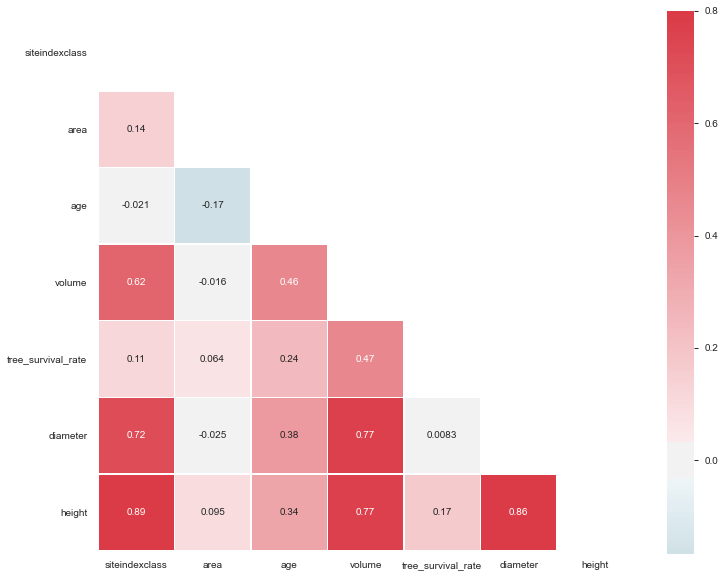

In [7]:
data = pd.concat([df_komaza], axis='columns')
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sb.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask,annot=True, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 1});

Siteindex class seems highly correlated with the tree size outcomes - height, diameter and volume. It should be an important factor while predicting these outcomes. In addition, there are no high correlations between the predictors, therefore no multicollinerity issues. 

### 2.1. Regression model (y - volume):
    
#### y - volume

#### X - siteindexclass, area, age, suitability, mgmthquality, field_manager, location, fa_zone.   


In [8]:
#remove variables that will not be needed in the independent variable list 
cols_independent_drop=df_komaza.drop(['volume','height','tree_survival_rate','diameter'], axis='columns')
cols_independent_drop.tail()

#creating dummies for categorical variables
X=pd.get_dummies(cols_independent_drop, columns=['suitability','mgmtquality','field_manager','location','fa_zone'])

#assigning volume as y - dependent variable
y=df_komaza.volume

#view of the final X - independend variable list
X.tail()


,siteindexclass,area,age,suitability_Marginally suitable,suitability_Moderately suitable,suitability_Not suitable,suitability_Out of scope,suitability_Suitable,suitability_Very suitable,mgmtquality_good,...,fa_zone_zone-01-186,fa_zone_zone-01-188,fa_zone_zone-01-189,fa_zone_zone-01-190,fa_zone_zone-01-195,fa_zone_zone-01-196,fa_zone_zone-01-197,fa_zone_zone-01-198,fa_zone_zone-01-199,fa_zone_zone-01-200
3733,18.0,0.17,3.08,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3734,14.0,0.00,3.08,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3735,14.0,0.01,3.08,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3736,12.0,0.00,3.08,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3737,18.0,0.02,3.08,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Next, I'm splitting my data into train (75%) and test (25%). Train will be used for training the model and test dataset will be used to evaluate the model predictive power at the end of the analysis. Basically, it will give me more confidence in the model accuracy and ensures that there's no issues with my results. 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [10]:
X_train.head()

,siteindexclass,area,age,suitability_Marginally suitable,suitability_Moderately suitable,suitability_Not suitable,suitability_Out of scope,suitability_Suitable,suitability_Very suitable,mgmtquality_good,...,fa_zone_zone-01-186,fa_zone_zone-01-188,fa_zone_zone-01-189,fa_zone_zone-01-190,fa_zone_zone-01-195,fa_zone_zone-01-196,fa_zone_zone-01-197,fa_zone_zone-01-198,fa_zone_zone-01-199,fa_zone_zone-01-200
2148,16.0,0.05,7.08,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
887,14.0,0.03,8.17,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2662,10.0,0.04,6.08,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
685,14.0,0.14,8.17,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
413,12.0,0.09,9.08,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3738 entries, 0 to 3737
Columns: 186 entries, siteindexclass to fa_zone_zone-01-200
dtypes: float64(3), uint8(183)
memory usage: 755.8 KB


#### Linear Regression (OLS) (using stats library) 

In [12]:
model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_train)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     28.06
Date:                Wed, 28 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:24:04   Log-Likelihood:                -11427.
No. Observations:                2616   AIC:                         2.319e+04
Df Residuals:                    2449   BIC:                         2.417e+04
Df Model:                         166                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
siteindexclass                      8.0446      0.187     42.941      0.000       7.677       8.412
area                              -36.4659      6.386     -5.710      0.000     -48.988     -23.944
age                                10.8213      0.386     28.001      0.000      10.064      11.579
suitability_Marginally suitable   -38.9428      3.269    -11.912      0.000     -45.353     -32.532
suitability_Moderately suitable   -36.9390      2.968    -12.445      0.000     -42.759     -31.119
suitability_Not suitable          -36.6647      2.826    -12.974      0.000     -42.206     -31.123
suitability_Out of scope          -38.8096      3.114    -12.462      0.000     -44.916     -32.703
suitability_Suitable              -46.8954     17.907     -2.619      0.009     -82.010     -11.780
suitability_Very suitable         -38.8182      3.234    -12.003      0.000     -45.160     -32.476
mgmtquality_good                  -53.3098      2.335    -22.829      0.000     -57.889     -48.731
mgmtquality_inaccessible          -65.8347      3.958    -16.631      0.000     -73.597     -58.072
mgmtquality_mid                   -57.1483      2.357    -24.244      0.000     -61.771     -52.526
mgmtquality_poor                  -60.7770      2.481    -24.497      0.000     -65.642     -55.912
field_manager_Alfred              -22.5191      2.715     -8.293      0.000     -27.844     -17.195
field_manager_Ann                 -26.9586      4.797     -5.620      0.000     -36.365     -17.552
field_manager_Erick               -28.4593      1.688    -16.864      0.000     -31.769     -25.150
field_manager_Joseph              -26.4220      3.828     -6.902      0.000     -33.929     -18.915
field_manager_Mathias             -27.3138      1.918    -14.242      0.000     -31.075     -23.553
field_manager_Nelson              -27.7596      2.484    -11.177      0.000     -32.630     -22.890
field_manager_No FM               -27.2015      1.762    -15.438      0.000     -30.657     -23.746
field_manager_Tyson               -25.7807      1.618    -15.935      0.000     -28.953     -22.608
field_manager_Winnie              -24.6551      2.171    -11.356      0.000     -28.913     -20.398
location_Bandari                  -17.1909      2.341     -7.344      0.000     -21.781     -12.601
location_Chakama                   15.7173     20.010      0.785      0.432     -23.520      54.955
location_Chasimba                  -9.1536      2.632     -3.478      0.001     -14.314      -3.993
location_Dida                      -8.5075      2.661     -3.197      0.001     -13.726      -3.289
location_Dungicha                 -17.7440      3.016     -5.883      0.000     -23.659     -11.829
location_Ganze                    -17.0203      1.986     -8.568      0.000     -20

- fa_zone variable is not significant. It seems like location and field_manager variables are more dominant and might have explained most it's variation.
- field manager, area, age and siteindexclass are all significant.

Model accuracy is quite weak - Adj R-Squared is at 0.65. Therefore, I will continue to investigate whether other algorithms such as Ridge, Lasso or Random Forest Regressor could be a better fit. In addition, I will perform feature transformation and examine if it can help to improve the model accuracy.

In [13]:
# Creating a method to run the cross validation of the model. 

def run_cross_validation(model, X_train, y_train, cv=10):
    scores = cross_val_score(model, X_train, y_train, cv=cv)

    print('List of fold scores is: {} '.format(scores))
    print('\n')
    print('The mean score is {}'.format(np.mean(scores)))

#### Linear Regression

In [14]:
lr = LinearRegression()

run_cross_validation(lr, X_train, y_train)

List of fold scores is: [-1.94208258e+15 -7.77223779e+17  5.86236710e-01 -4.72677874e+18
 -1.92700981e+17 -3.18107967e+14  6.46350989e-01  6.31727304e-01
 -1.93533961e+18 -1.34307110e+21] 


The mean score is -1.3507054052028808e+20


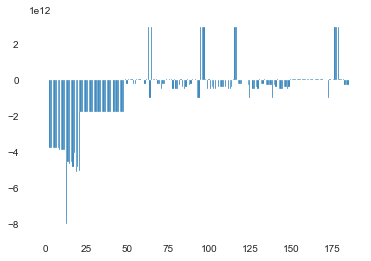

In [15]:
from matplotlib import pyplot
model = LinearRegression()
model.fit(X_train, y_train)
# get importance
importance = model.coef_
# summarize feature importance
#for i,v in enumerate(importance):
#	print('Feature: %0d, Score: %.2f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#### Ridge Regression

In [16]:
ridge=Ridge()

run_cross_validation(ridge, X_train, y_train)

List of fold scores is: [0.57786336 0.56457088 0.59384337 0.63249616 0.54217422 0.58112311
 0.64624262 0.64585788 0.68450555 0.58637173] 


The mean score is 0.6055048872632133


#### Lasso Regression

In [17]:
lasso = Lasso()

run_cross_validation(lasso, X_train, y_train)

List of fold scores is: [0.61025411 0.58872342 0.60186395 0.63349671 0.512536   0.60307851
 0.62254845 0.64345284 0.68295254 0.60079119] 


The mean score is 0.6099697724780687


#### Random Forest Regression

In [18]:
rf = RandomForestRegressor(n_estimators=50, random_state=0)
print('Running cross validation .....')
run_cross_validation(rf, X_train, y_train, cv=5)

Running cross validation .....
List of fold scores is: [0.65485354 0.65983789 0.6352737  0.74561748 0.70720597] 


The mean score is 0.6805577160563188


Comparing the results for Linear Regression (0.63), Lasso Regression (0.57), Ridge Regression (0.63) and Random Forest Regression (0.67), I can see that Random Forest Regression performed the best (0.67 R-Adjusted). Lasso and Ridge performed equally or lower than the Linear Regression model. Therefore, I will only use Random Forest Regression and Linear Regression in the following steps. In addition, overall the model predictive power is relatively low. I will investigate several potential solutions:
- scaling the variables
- examining the outliers
- reducing the dimensions for high cardinality variables, such as fa_zone and location.
- potentially adding polynomial features

### Scaling the numeric variables

In [19]:
numeric_cols = ['siteindexclass', 'area', 'age']
scaler = StandardScaler()

scaled_train = pd.DataFrame(scaler.fit_transform(X_train[numeric_cols]), columns = numeric_cols)
scaled_test = pd.DataFrame(scaler.transform(X_test[numeric_cols]), columns = numeric_cols)

X_train.reset_index(drop=True, inplace=True)
X_train.drop(numeric_cols, axis=1, inplace=True)
X_train = pd.concat([X_train, scaled_train], axis=1)


X_test.reset_index(drop=True, inplace=True)
X_test.drop(numeric_cols, axis=1, inplace=True)
X_test = pd.concat([X_test, scaled_test], axis=1)

NameError: name 'StandardScaler' is not defined

#### Repeating the Random Forest Regression to see if scaling the variables has helped with the predictive model 

In [ ]:
rf = RandomForestRegressor(n_estimators=50, random_state=0)
print('Running cross validation .....')
run_cross_validation(rf, X_train, y_train, cv=5)

Scaling the numeric variables has a significant effect on the Random Forest Regression accuracy - Adj R-Squared increased up to 0.67.

### Dimension reduction

I will be reducing the number of categories for variables that have high cardinality. I will maintain 10 most common categories and merge the remaining ones into one category called Other.

In [ ]:
# reducing the number of dimensions up to 10 categories

df_komaza['location'] = df_komaza['location'].astype('category')
others = df_komaza['location'].value_counts().index[10:]
label = 'Other'
df_komaza['location'] = df_komaza['location'].cat.add_categories([label])
df_komaza['location'] = df_komaza['location'].replace(others, label)
df_komaza['location'].value_counts(normalize=True)


# reducing the number of dimensions up to 10 categories
df_komaza['fa_zone'] = df_komaza['fa_zone'].astype('category')
others = df_komaza['fa_zone'].value_counts().index[10:]
label = 'Other'
df_komaza['fa_zone'] = df_komaza['fa_zone'].cat.add_categories([label])
df_komaza['fa_zone'] = df_komaza['fa_zone'].replace(others, label)
df_komaza['fa_zone'].value_counts(normalize=True)


In [ ]:
#remove variables that will not be needed in the independent variable list 
cols_independent_drop=df_komaza.drop(['volume','height','tree_survival_rate','diameter'], axis='columns')
cols_independent_drop.tail()

#creating dummies for categorical variables
X=pd.get_dummies(cols_independent_drop, columns=['suitability','mgmtquality','field_manager','location','fa_zone'])

#assigning volume as y - dependent variable
y=df_komaza.volume

#view of the final X - independend variable list
X.tail()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [ ]:
X_train.head()

Reduced the number of columns from 186 columns to 44 columns.

#### Linear Regression

In [ ]:
model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_train)
model.summary()

#### Random Forest Regression

In [ ]:
rf = RandomForestRegressor(n_estimators=50, random_state=0)
print('Running cross validation .....')
run_cross_validation(rf, X_train, y_train, cv=5)

In [ ]:
rf = RandomForestRegressor(n_estimators=50, random_state=0)
print('Running cross validation .....')
run_cross_validation(rf, X_test, y_test, cv=5)

In [ ]:
rf.fit(X_train, y_train)
rf.feature_importances_

#### Outlier Investigation

Looking at pandas profile report and the scatterplots, I can see that there are some obvious outliers. Since this data is based on the measurements in the field, data quality issues might be a likely concern. However, I will investigate what effect does it have on the modeling and decide if it's apppropriate to drop these outliers.  

In [ ]:
#Investogating outliers in relation to the dependent variable - volume

fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(15, 4))
axes = np.ravel(axes)
col_name = ['diameter','height','age','area','tree_survival_rate']
for i, c in zip(range(5), col_name):
    df_komaza.plot.scatter(ax=axes[i], x=c, y='volume', sharey=True, colorbar=False, c='g')

#### Removing outliers
In order to examine how the model would perform without outliers, I will drop them and create a new dataset. 

In [ ]:
#separate numerical variables for outlier investigation
columns_num = ['diameter','volume','height','area']
df_numeric=df_komaza[columns_num]

# Thereshold for considering a point an outlier will be 2 standard deviations 
z = np.abs(stats.zscore(df_numeric))

#print(z)
threshold = 2

#print(np.where(z > 2))

#I will craete a new dataframe which will have no outliers. This will allow me to run the two model versions (full dataset vs. dataset with no outliers) and compare the results.  
df_komaza_o = df_komaza[(z < 2).all(axis=1)]
df_komaza_o.shape

In [ ]:
#remove variables that will not be needed in the independent variable list 
cols_independent_drop=df_komaza_o.drop(['volume','height','tree_survival_rate','diameter'], axis='columns')
cols_independent_drop.tail()

#creating dummies for categorical variables
X=pd.get_dummies(cols_independent_drop, columns=['suitability','mgmtquality','field_manager','location','fa_zone'])

#assigning volume as a dependent variable
y=df_komaza_o.volume
X.tail()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

#### Linear Regression

In [ ]:
model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_train)
model.summary()

#### Random Forest Regression

In [ ]:
rf = RandomForestRegressor(n_estimators=50, random_state=0)
print('Running cross validation .....')
run_cross_validation(rf, X_train, y_train, cv=5)

Removing outliers has almost no impact on the linear regression model, however it has reduced the Random Forest Regression predictive power. In addition, I do not have sufficient information about the outliers to decide whether these points are errors or just natural outliers that might be useful for my analysis. 

### 2. Regression model (y - diameter)
    
#### y - diameter

#### X - area, age, fa_zone, suitability, mgmthquality, siteindexclass, field_manager, location   
   

In [ ]:
cols_independent_drop=df_komaza.drop(['diameter','volume','height','tree_survival_rate'], axis='columns')
cols_independent_drop.tail()
X=pd.get_dummies(cols_independent_drop, columns=['suitability','mgmtquality','field_manager','location','fa_zone'])
X.tail()
y=df_komaza.diameter
X.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

#### Linear Regression

In [ ]:
model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X)
model.summary()

#### Random Forest Regression

In [ ]:
rf = RandomForestRegressor(n_estimators=50, random_state=0)
print('Running cross validation .....')
run_cross_validation(rf, X_train, y_train, cv=5)

In [ ]:
rf = RandomForestRegressor(n_estimators=50, random_state=0)
print('Running cross validation .....')
run_cross_validation(rf, X_test, y_test, cv=5)

### 3. Regression model (y - height)
    
#### y - height

#### X - area, age, fa_zone, suitability, mgmthquality, siteindexclass, field_manager, location   


In [ ]:
cols_independent_drop=df_komaza.drop(['diameter','volume','tree_survival_rate','height'], axis='columns')
cols_independent_drop.tail()
X=pd.get_dummies(cols_independent_drop, columns=['suitability','mgmtquality','field_manager','location','fa_zone'])
X.tail()
y=df_komaza.height
X.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [ ]:
model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X)
model.summary()


In [ ]:
rf = RandomForestRegressor(n_estimators=50, random_state=0)
print('Running cross validation .....')
run_cross_validation(rf, X_train, y_train, cv=5)

In [ ]:
rf = RandomForestRegressor(n_estimators=50, random_state=0)
print('Running cross validation .....')
run_cross_validation(rf, X_test, y_test, cv=5)

### 4. Regression model (y - tree survival rate)
    
#### y - tree survival rate

#### X - area, age, fa_zone, suitability, mgmthquality, siteindexclass, field_manager, location   

In [ ]:
cols_independent_drop=df_komaza.drop(['diameter','volume','tree_survival_rate','height'], axis='columns')
cols_independent_drop.tail()
X=pd.get_dummies(cols_independent_drop, columns=['suitability','mgmtquality','field_manager','location','fa_zone'])

y=df_komaza.tree_survival_rate
#X.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [ ]:
model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X)
model.summary()

In [ ]:
rf = RandomForestRegressor(n_estimators=50, random_state=0)
print('Running cross validation .....')
run_cross_validation(rf, X_train, y_train, cv=5)

In [ ]:
rf = RandomForestRegressor(n_estimators=50, random_state=0)
print('Running cross validation .....')
run_cross_validation(rf, X_test, y_test, cv=5)